In [28]:
### FATİH ÇAĞATAY GÜLMEZ
### CS340 ASSIGNMENT 1

##INITIALIZATION

# Reading .csv file and creating a RDD, Spark Generated code.
import time

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_4144cbc03d8e478aa7890f51134abd45(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', 'c8c3a94f3b384de3bfb123dca37f5455')
    hconf.set(prefix + '.username', '07ac97106bd9416e93058c183c4e40db')
    hconf.set(prefix + '.password', 'ir(30c.hp}QdpYdu')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_4144cbc03d8e478aa7890f51134abd45(name)

df_data_1 = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='true', inferschema='true')\
  .load("swift://CS340." + name + "/triangles.csv")

rdd = sc.textFile(("swift://CS340." + name + "/triangles.csv"))


In [3]:
## PART I

#Distance of two points (Pisagor)
def dist(point1, point2):
    return (((point1[0] - point2[0])**2)+((point1[1] - point2[1])**2))**(0.5)

#Triangle Inequality implementation, returns true if points represents a triangle.
def is_triangle(i):
    x = i.split(", ")
    ver1 = int(x[0].split(" ")[0]), int(x[0].split(" ")[1])
    ver2 = int(x[1].split(" ")[0]), int(x[1].split(" ")[1])
    ver3 = int(x[2].split(" ")[0]), int(x[2].split(" ")[1])

    edge_1 = dist(ver1, ver2)
    edge_2 = dist(ver1, ver3)
    edge_3 = dist(ver2, ver3)

    if not (edge_1 + edge_2 > edge_3 and abs(edge_1 - edge_2) < edge_3):
        return False
    elif not (edge_1 + edge_3 > edge_2 and abs(edge_1 - edge_3) < edge_2):
        return False
    elif not (edge_3 + edge_2 > edge_1 and abs(edge_3 - edge_2) < edge_1):
        return False
    else:
        return True

# Triangular Points containing RDD.
triangles = rdd.filter(is_triangle)



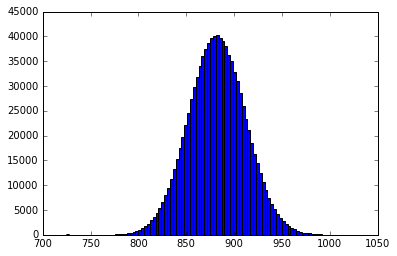

In [29]:
## PART II

#It will be used several times, so persisting it.
triangles.partitionBy(100).persist()

def point1(triangle):
    triangle = triangle.split(", ")
    v1 = int(triangle[0].split(" ")[0]), int(triangle[0].split(" ")[1])
    return (v1, 1)

def point2(triangle):
    triangle = triangle.split(", ")
    v1 = int(triangle[1].split(" ")[0]), int(triangle[1].split(" ")[1])
    return (v1, 1)

def point3(triangle):
    triangle = triangle.split(", ")
    v1 = int(triangle[2].split(" ")[0]), int(triangle[2].split(" ")[1])    
    return (v1, 1)


common_points_dict = sc.union([triangles.map(point1), triangles.map(point2), triangles.map(point3)]).reduceByKey(lambda x,y: x+y).collectAsMap()

common_points_dict[(0, 1)]

def neighbours(x):
    x = x.split(", ")
    ver1 = (int(x[0].split(" ")[0]), int(x[0].split(" ")[1]))
    ver2 = (int(x[1].split(" ")[0]), int(x[1].split(" ")[1]))
    ver3 = (int(x[2].split(" ")[0]), int(x[2].split(" ")[1]))
    
    co = common_points_dict[ver1] + common_points_dict[ver2] + common_points_dict[ver3]
    
    return (co-3, 1)

triangles_neighbour = triangles.map(neighbours)
dataset = triangles_neighbour.map(lambda x: x[0]).collect()
#triangles_neighbour.take(5)

%matplotlib inline
import matplotlib.pyplot as plt

#plt.scatter(*zip(*dataset), bins = 100)
plt.hist(dataset, bins = 100)
plt.show()


In [30]:
#average = 
triangles_neighbour.map(lambda x: x[0]).sum()/triangles_neighbour.map(lambda x: x[0]).count()

881

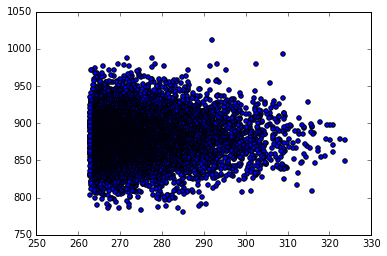

In [36]:
## PART III
def dist(point1, point2):
    return (((point1[0] - point2[0])**2)+((point1[1] - point2[1])**2))**(0.5)

def circumference(triangle):
    x = triangle.split(", ")
    ver1 = int(x[0].split(" ")[0]), int(x[0].split(" ")[1])
    ver2 = int(x[1].split(" ")[0]), int(x[1].split(" ")[1])
    ver3 = int(x[2].split(" ")[0]), int(x[2].split(" ")[1])

    edge_1 = dist(ver1, ver2)
    edge_2 = dist(ver1, ver3)
    edge_3 = dist(ver2, ver3)
    
    return edge_1 + edge_2 + edge_3

dataset2 = triangles.map(lambda x: (circumference(x), neighbours(x)[0])).top(10000)
plt.scatter(*zip(*dataset2))
plt.show()